# Introduction
Here we process the data from the electron microscopy 3D dataset, the first lines automatically download it if you have Kaggle setup otherwise you can download the dataset [here](https://www.epfl.ch/labs/cvlab/data/data-em/)

You need:
- Training sub volume
- Ground truth sub volume

Save the images in the sub folder "input".

In [17]:
import os
if not os.path.exists('input'):
    !kaggle datasets download -d kmader/electron-microscopy-3d-segmentation -wp emdata
    !mkdir input
    !mv emdata/* input
    !cd input/ && unzip *.zip

In [18]:
import matplotlib.patches as mpatches  # for showing rectangles and annotations
from skimage.color import label2rgb  # for making overlay plots
import numpy as np  # for matrix operations and array support
from skimage.measure import regionprops  # for shape analysis
from skimage.measure import label  # for labeling regions
import matplotlib.pyplot as plt  # for showing plots
from skimage.io import imread  # for reading images
%matplotlib inline

# Connected Component Labeling
scikit-image has basic support for [connected component labeling](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label) and we can do some small demos with the label function and small test images, before moving onto bigger datasets. 

## Neighborhood
In the course we use the term neighborhood and here we use the term ```connectivity``` for the same idea. 

 - For a 2D image a connectivity = 1 is just the 4-neighborhood (or pixels that share an edge, connectivity = 2 is then 8-neighborhood (or pixels that share a vertex).

In [19]:
# simple test image diagonal
test_img = np.eye(4)
print('Input Image')
print(test_img)

test_label_4 = label(test_img, connectivity=1)
print('Labels with 4-neighborhood')
print(test_label_4)

test_label_8 = label(test_img, connectivity=2)
print('Labels with 8-neighborhood')
print(test_label_8)

Input Image
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Labels with 4-neighborhood
[[1 0 0 0]
 [0 2 0 0]
 [0 0 3 0]
 [0 0 0 4]]
Labels with 8-neighborhood
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


## 3D Neighborhood

For a 3D image a connectivity = 1 is just the 6-neighborhood (or voxels that share an face, connectivity = 2 is then voxels that share an edge and 3 is voxels that share a vertex

In [20]:
test_img = np.array(
    [1 if x in [0, 13, 26] else 0 for x in range(27)]).reshape((3, 3, 3))
print('Input Image')
print(test_img)

test_label_1 = label(test_img, connectivity=1)
print('Labels with Face-sharing')
print(test_label_1)

test_label_2 = label(test_img, connectivity=2)
print('Labels with Edge-Sharing')
print(test_label_2)

test_label_3 = label(test_img, connectivity=3)
print('Labels with Vertex-Sharing')
print(test_label_3)

Input Image
[[[1 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 1]]]
Labels with Face-sharing
[[[1 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 2 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 3]]]
Labels with Edge-Sharing
[[[1 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 2 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 3]]]
Labels with Vertex-Sharing
[[[1 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 1]]]


In [21]:
import os
import numpy as np


def imread_or_invent(in_path):
    np.random.seed(2018)
    if os.path.exists(in_path):
        return imread(in_path)
    else:
        print('Getting creative...')
        fake_shape = (10, 50, 75)
        if 'groundtruth' in in_path:
            return (np.random.uniform(0, 1, size=fake_shape) > 0.99).astype(int)
        else:
            return np.random.uniform(0, 1, size=fake_shape)


em_image_vol = imread_or_invent('input/training.tif')
em_thresh_vol = imread_or_invent('input/training_groundtruth.tif')
print("Data Loaded, Dimensions", em_image_vol.shape, '->', em_thresh_vol.shape)

Data Loaded, Dimensions (165, 768, 1024) -> (165, 768, 1024)


# 2D Analysis
Here we work with a single 2D slice to get started and take it randomly from the middle

In [22]:
em_idx = np.random.permutation(range(em_image_vol.shape[0]))[0]
em_slice = em_image_vol[em_idx]
em_thresh = em_thresh_vol[em_idx]
print("Slice Loaded, Dimensions", em_slice.shape)

Slice Loaded, Dimensions (768, 1024)


Text(0.5, 1.0, 'Overlayed')

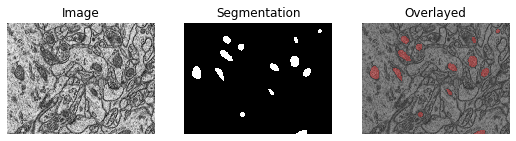

In [23]:
# show the slice and threshold
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4))
ax1.imshow(em_slice, cmap='gray')
ax1.axis('off')
ax1.set_title('Image')
ax2.imshow(em_thresh, cmap='gray')
ax2.axis('off')
ax2.set_title('Segmentation')
# here we mark the threshold on the original image

ax3.imshow(label2rgb(em_thresh, em_slice, bg_label=0))
ax3.axis('off')
ax3.set_title('Overlayed')

13 number of labels


Text(0.5, 1.0, 'Overlayed')

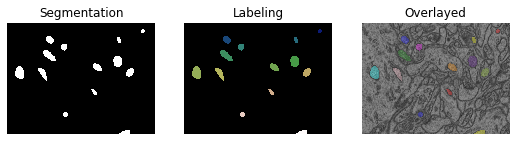

In [24]:
# make connected component labels
em_label = label(em_thresh)
print(em_label.max(), 'number of labels')
# show the segmentation, labels and overlay
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4))
ax1.imshow(em_thresh, cmap='gray')
ax1.axis('off')
ax1.set_title('Segmentation')
ax2.imshow(em_label, cmap=plt.cm.gist_earth)
ax2.axis('off')
ax2.set_title('Labeling')
# here we mark the threshold on the original image

ax3.imshow(label2rgb(em_label, em_slice, bg_label=0))
ax3.axis('off')
ax3.set_title('Overlayed')

# Shape Analysis 
For shape analysis we use the regionprops function which calculates the area, perimeter, and other features for a shape. The analysis creates a list of these with one for each label in the original image.

In [25]:
shape_analysis_list = regionprops(em_label)
first_region = shape_analysis_list[0]
print('List of region properties for', len(shape_analysis_list), 'regions')
print('Features Calculated:', ', '.join(
    [f for f in dir(first_region) if not f.startswith('_')]))

List of region properties for 13 regions
Features Calculated: area, bbox, bbox_area, centroid, convex_area, convex_image, coords, eccentricity, equivalent_diameter, euler_number, extent, filled_area, filled_image, image, inertia_tensor, inertia_tensor_eigvals, intensity_image, label, local_centroid, major_axis_length, max_intensity, mean_intensity, min_intensity, minor_axis_length, moments, moments_central, moments_hu, moments_normalized, orientation, perimeter, slice, solidity, weighted_centroid, weighted_local_centroid, weighted_moments, weighted_moments_central, weighted_moments_hu, weighted_moments_normalized


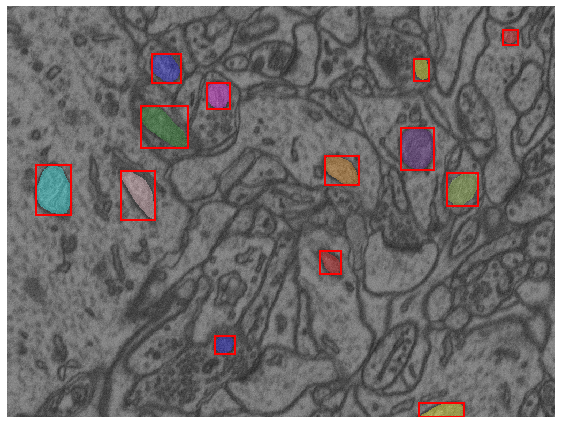

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(label2rgb(em_label, em_slice, bg_label=0))

for region in shape_analysis_list:
    # draw rectangle using the bounding box
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()

## Anisotropy
We can calculate anisotropy as we did in the course by using the largest and shortest lengths, called here as ```major_axis_length``` and ```minor_axis_length``` respectively

- Try using different formulas for anisotropy to see how it changes what is shown

$$ Aiso1 = \frac{\text{Longest Side}}{\text{Shortest Side}} - 1 $$

$$ Aiso2 = \frac{\text{Longest Side}-\text{Shortest Side}}{\text{Longest Side}} $$

$$ Aiso3 = \frac{\text{Longest Side}}{\text{Average Side Length}} - 1 $$

$$ Aiso4 = \frac{\text{Longest Side}-\text{Shortest Side}}{\text{Average Side Length}} $$

Label: 1 Anisotropy 0.02
Label: 2 Anisotropy 0.13
Label: 3 Anisotropy 0.22
Label: 4 Anisotropy 0.06
Label: 5 Anisotropy 0.43
Label: 6 Anisotropy 0.12
Label: 7 Anisotropy 0.27
Label: 8 Anisotropy 0.19
Label: 9 Anisotropy 0.47
Label: 10 Anisotropy 0.19
Label: 11 Anisotropy 0.32
Label: 12 Anisotropy 0.06
Label: 13 Anisotropy 0.50


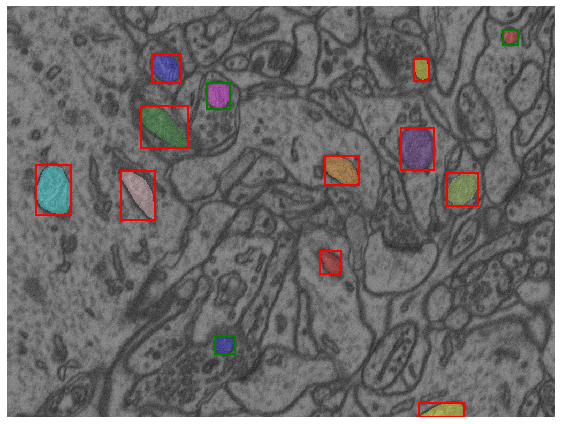

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(label2rgb(em_label, em_slice, bg_label=0))

for region in shape_analysis_list:
    x1 = region.major_axis_length
    x2 = region.minor_axis_length
    anisotropy = (x1-x2)/np.clip(x1+x2, 0.1, 9999)
    # for anisotropic shapes use red for the others use blue
    print('Label:', region.label, 'Anisotropy %2.2f' % anisotropy)
    if anisotropy > 0.1:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
    else:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()

# Tasks
- Perform the analysis in 3D
- Find the largest and smallest structures
- Find the structures with the highest and lowest 3D anisotropy